# ADS 509 Assignment 5.1: Topic Modeling

This notebook holds Assignment 5.1 for Module 5 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In this assignment you will work with a categorical corpus that accompanies `nltk`. You will build the three types of topic models described in Chapter 8 of _Blueprints for Text Analytics using Python_: NMF, LSA, and LDA. You will compare these models to the true categories. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [1]:
# These libraries may be useful to you

#!pip install pyLDAvis==3.4.1 --user  #You need to restart the Kernel after installation.
# You also need a Python version => 3.9.0
from nltk.corpus import brown

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import pyLDAvis
import pyLDAvis.lda_model
import pyLDAvis.gensim_models

import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

from spacy.lang.en.stop_words import STOP_WORDS as stopwords

from collections import Counter, defaultdict

nlp = spacy.load('en_core_web_sm')

/Users/smsultanmahmudrahat/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# add any additional libaries you need here

import nltk
from nltk.corpus import brown

# Download the Brown corpus
nltk.download('brown')

[nltk_data] Downloading package brown to
[nltk_data]     /Users/smsultanmahmudrahat/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


True

In [2]:
# This function comes from the BTAP repo.

def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

## Getting to Know the Brown Corpus

Let's spend a bit of time getting to know what's in the Brown corpus, our NLTK example of an "overlapping" corpus.

In [5]:
# categories of articles in Brown corpus
for category in brown.categories() :
    print(f"For {category} we have {len(brown.fileids(categories=category))} articles.")

For adventure we have 29 articles.
For belles_lettres we have 75 articles.
For editorial we have 27 articles.
For fiction we have 29 articles.
For government we have 30 articles.
For hobbies we have 36 articles.
For humor we have 9 articles.
For learned we have 80 articles.
For lore we have 48 articles.
For mystery we have 24 articles.
For news we have 44 articles.
For religion we have 17 articles.
For reviews we have 17 articles.
For romance we have 29 articles.
For science_fiction we have 6 articles.


Let's create a dataframe of the articles in of hobbies, editorial, government, news, and romance.

In [6]:
categories = ['editorial','government','news','romance','hobbies'] 

category_list = []
file_ids = []
texts = []

for category in categories : 
    for file_id in brown.fileids(categories=category) :
        
        # build some lists for a dataframe
        category_list.append(category)
        file_ids.append(file_id)
        
        text = brown.words(fileids=file_id)
        texts.append(" ".join(text))

        
        
df = pd.DataFrame()
df['category'] = category_list
df['id'] = file_ids
df['text'] = texts 

df.shape

(166, 3)

In [7]:
# Let's add some helpful columns on the df
df['char_len'] = df['text'].apply(len)
df['word_len'] = df['text'].apply(lambda x: len(x.split()))


<Axes: xlabel='category'>

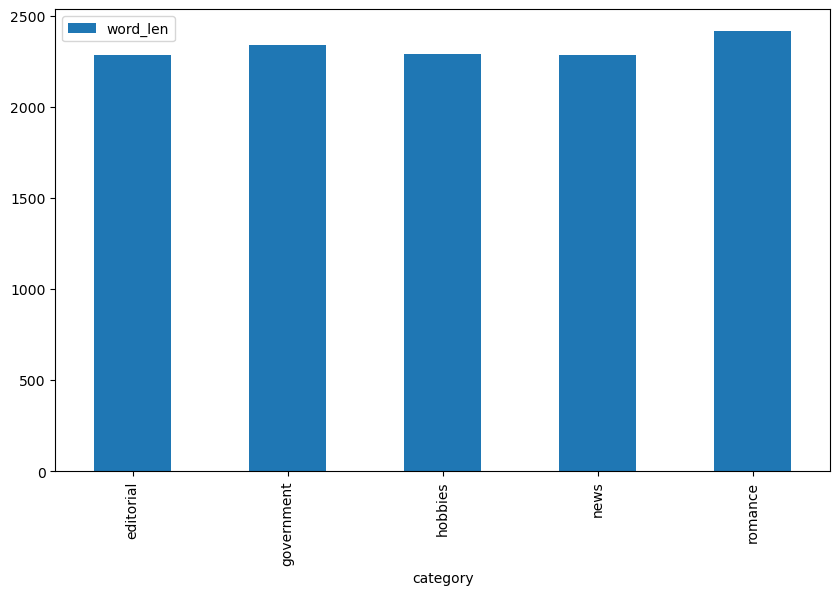

In [8]:
%matplotlib inline
df.groupby('category').agg({'word_len': 'mean'}).plot.bar(figsize=(10,6))

Now do our TF-IDF and Count vectorizations.

In [9]:
count_text_vectorizer = CountVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(df["text"])
count_text_vectors.shape

/opt/homebrew/Caskroom/miniforge/base/envs/ads502/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


(166, 4941)

In [10]:
tfidf_text_vectorizer = TfidfVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['text'])
tfidf_text_vectors.shape

(166, 4941)

Q: What do the two data frames `count_text_vectors` and `tfidf_text_vectors` hold? 

A: `tfidf_text_vectors` and `count_text_vectors` is a sparse matrix but . Both of them ignore terms that appear in fewer than 5 documents and ignore terms that appear in more than 70% of the documents also, both of them remove lists of the stop words.

- `count_text_vectors` matrix holds raw counts of how many times each term appears in each documents and `tfidf_text_vectors` shows TF-IDF scores, which take into account not just the frequency of terms in a document but also how common or rare the terms are across all documents.


## Fitting a Non-Negative Matrix Factorization Model

In this section the code to fit a five-topic NMF model has already been written. This code comes directly from the [BTAP repo](https://github.com/blueprints-for-text-analytics-python/blueprints-text), which will help you tremendously in the coming sections. 

In [14]:
nmf_text_model = NMF(n_components=5, random_state=314)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

In [15]:
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  mr (0.51)
  president (0.45)
  kennedy (0.43)
  united (0.42)
  khrushchev (0.40)

Topic 01
  said (0.88)
  didn (0.46)
  ll (0.45)
  thought (0.42)
  man (0.37)

Topic 02
  state (0.39)
  development (0.36)
  tax (0.33)
  sales (0.30)
  program (0.25)

Topic 03
  mrs (2.61)
  mr (0.78)
  said (0.63)
  miss (0.52)
  car (0.51)

Topic 04
  game (1.02)
  league (0.74)
  ball (0.72)
  baseball (0.71)
  team (0.66)


Now some work for you to do. Compare the NMF factorization to the original categories from the Brown Corpus.

We are interested in the extent to which our NMF factorization agrees or disagrees with the original categories in the corpus. For each topic in your NMF model, tally the Brown categories and interpret the results. 


In [19]:

# assign each document to the topic with the highest weight
document_topics = np.argmax(W_text_matrix, axis=1)

# Tally Brown categories for each topic
topic_category_tallies = defaultdict(Counter)

for doc_index, topic in enumerate(document_topics):
    doc_category = df['category'][doc_index]
    topic_category_tallies[topic][doc_category] += 1
    


for topic, category_tally in topic_category_tallies.items():
    print(f"Topic {topic:02}")
    for category, count in category_tally.items():
        print(f"  {category}: {count}")

Topic 02
  editorial: 2
  government: 26
  news: 11
  hobbies: 26
Topic 00
  editorial: 20
  government: 4
  news: 8
Topic 01
  editorial: 4
  romance: 29
  hobbies: 8
Topic 04
  editorial: 1
  news: 8
  hobbies: 1
Topic 03
  news: 17
  hobbies: 1


Q: How does your five-topic NMF model compare to the original Brown categories? 

A: **Topic 00**

**Top Words:**

- mr (0.51)
- president (0.45)
- kennedy (0.43)
- united (0.42)
- khrushchev (0.40)

Brown Categories:

- editorial: 20
- government: 4
- news: 8

This topic seems to be heavily related to political or governmental content, with prominent words like "president," "kennedy," "united," and "khrushchev." The categories that align well with this topic are primarily editorial and news, with a smaller representation from government.

 ** Topic 01**
**Top Words:**
- said (0.88)
- didn (0.46)
- ll (0.45)
- thought (0.42)
- man (0.37)

**Brown Categories:**
- editorial: 4
- romance: 29
- hobbies: 8

This topic is to be centered around dialogue and personal narratives which is  indicated by words like "said," "didn," and "thought." It aligns with the romance category, which typically includes personal stories and dialogue, and also has a presence in hobbies and editorial.

**Topic 02** </br> 
**Top Words:**
- state (0.39)
- development (0.36)
- tax (0.33)
- sales (0.30)
- program (0.25)

**Brown Categories:**
- editorial: 2
- government: 26
- news: 11
- hobbies: 26


This topic is likely related to economic or governmental themes, as indicated by terms like "state," "development," "tax," and "sales." It aligns well with the government category and has a significant representation in hobbies and news, suggesting a mix of economic and policy-related content.

**Topic 03** </br>
**Top Words:**
- mrs (2.61)
- mr (0.78)
- said (0.63)
- miss (0.52)
- car (0.51)

**Brown Categories:**
- news: 17
- hobbies: 1


This topic is centered around personal titles and speech, with a particular emphasis on individuals (e.g., "mrs," "mr," "miss"). It aligns mostly with the news category, suggesting articles that include personal accounts or interviews, and has a minimal representation in hobbies.

#### Topic 04
**Top Words:**
- game (1.02)
- league (0.74)
- ball (0.72)
- baseball (0.71)
- team (0.66)

**Brown Categories:**
- editorial: 1
- news: 8
- hobbies: 1

This topic is clearly related to sports, as indicated by terms like "game," "league," "ball," and "baseball." It primarily aligns with the news category, likely reflecting sports news articles, with minor representation in editorial and hobbies.

## Fitting an LSA Model

In this section, follow the example from the repository and fit an LSA model (called a "TruncatedSVD" in `sklearn`). Again fit a five-topic model and compare it to the actual categories in the Brown corpus. Use the TF-IDF vectors for your fit, as above. 

To be explicit, we are once again interested in the extent to which this LSA factorization agrees or disagrees with the original categories in the corpus. For each topic in your model, tally the Brown categories and interpret the results. 


In [22]:
# Your code here
from sklearn.decomposition import TruncatedSVD

# Fit the LSA model
lsa_text_model = TruncatedSVD(n_components=5, random_state=314)
W_lsa_matrix = lsa_text_model.fit_transform(tfidf_text_vectors)
H_lsa_matrix = lsa_text_model.components_

# Assign each document to the topic with the highest weight
lsa_document_topics = np.argmax(W_lsa_matrix, axis=1)

# Tally Brown categories for each topic
lsa_topic_category_tallies = defaultdict(Counter)

for doc_index, topic in enumerate(lsa_document_topics):
    doc_category = df['category'][doc_index]
    lsa_topic_category_tallies[topic][doc_category] += 1

# display the results
for topic, category_tally in lsa_topic_category_tallies.items():
    print(f"Topic {topic:02}")
    for category, count in category_tally.items():
        print(f"  {category}: {count}")

# display topics for LSA model
display_topics(lsa_text_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  editorial: 27
  government: 30
  news: 34
  romance: 21
  hobbies: 36
Topic 04
  news: 7
Topic 03
  news: 3
Topic 01
  romance: 8

Topic 00
  said (0.44)
  mr (0.25)
  mrs (0.22)
  state (0.20)
  man (0.17)

Topic 01
  said (3.89)
  ll (2.73)
  didn (2.63)
  thought (2.20)
  got (1.97)

Topic 02
  mrs (3.12)
  mr (1.70)
  said (1.06)
  kennedy (0.82)
  khrushchev (0.77)

Topic 03
  mrs (29.45)
  club (6.53)
  game (6.12)
  jr (5.60)
  university (5.20)

Topic 04
  game (4.54)
  league (3.27)
  baseball (3.22)
  ball (3.10)
  team (2.94)



**Topic 0**

**Top Words:**
- said (0.44)
- mr (0.25)
- mrs (0.22)
- state (0.20)
- man (0.17)

**Brown Categories:**
- editorial: 27
- government: 30
- news: 34
- romance: 21
- hobbies: 36


This topic seems to be a general one, covering a wide range of subjects. The presence of common words like "said," "mr," and "mrs" indicates that it includes a lot of spoken or reported content. This is reflected in the broad distribution across editorial, government, news, romance, and hobbies categories, suggesting that this topic may represent common language used in various contexts.


**Topic 01**

**Top Words:**
- said (3.89)
- ll (2.73)
- didn (2.63)
- thought (2.20)
- got (1.97)

**Brown Categories:**
- romance: 8


This topic appears to be centered around dialogue and personal thoughts, as indicated by words like "said," "thought," "didn," and "ll." It aligns strongly with the romance category, which typically features narratives and conversations. This focused alignment suggests that this topic captures the storytelling and conversational elements prevalent in romance texts.



Q: How does your five-topic LSA model compare to the original Brown categories? 



-  Topic 02 </br>
**Top Words:**
- mrs (3.12)
- mr (1.70)
- said (1.06)
- kennedy (0.82)
- khrushchev (0.77)

**Brown Categories:**

This topic is likely related to personal titles and significant individuals, possibly in historical or political contexts, given the names "Kennedy" and "Khrushchev." The presence of "mrs" and "mr" suggests a focus on individuals. The lack of specific category data makes detailed interpretation challenging, but it could relate to editorial or news articles discussing prominent figures.

**Topic 3** </br>

**Top Words:**
- mrs (29.45)
- club (6.53)
- game (6.12)
- jr (5.60)
- university (5.20)

**Brown Categories:**
- news: 3

This topic appears to be related to social and recreational activities, indicated by words like "club," "game," and "university." The high frequency of "mrs" suggests a possible focus on social clubs or activities involving women. The alignment with the news category suggests that this topic may cover news about social events or clubs.


**`Topic 04`**
**Top Words:**
- game (4.54)
- league (3.27)
- baseball (3.22)
- ball (3.10)
- team (2.94)

**Brown Categories:**
- news: 7


This topic is clearly related to sports, with terms like "game," "league," "baseball," and "team." The alignment with the news category suggests that this topic likely covers sports news, including games, leagues, and team activities.

In [23]:
display_topics(lsa_text_model, tfidf_text_vectorizer.get_feature_names_out())



Topic 00
  said (0.44)
  mr (0.25)
  mrs (0.22)
  state (0.20)
  man (0.17)

Topic 01
  said (3.89)
  ll (2.73)
  didn (2.63)
  thought (2.20)
  got (1.97)

Topic 02
  mrs (3.12)
  mr (1.70)
  said (1.06)
  kennedy (0.82)
  khrushchev (0.77)

Topic 03
  mrs (29.45)
  club (6.53)
  game (6.12)
  jr (5.60)
  university (5.20)

Topic 04
  game (4.54)
  league (3.27)
  baseball (3.22)
  ball (3.10)
  team (2.94)


Q: What is your interpretation of the display topics output? 

A: 
`topic 00`: 

This topic seems to be centered around general reporting or dialogue. The word "said" is dominant, suggesting a focus on speech or quotations. Words like "mr," "mrs," "state," and "man" indicate that this topic might cover a range of subjects from personal titles to state affairs, which aligns with various categories such as editorial, news, and government

`topic 01`:

This topic is heavily focused on dialogue and personal reflections. The frequent use of words like "said," "ll," "didn," and "thought" indicates that this topic is related to conversations and inner thoughts. This aligns well with categories like romance and personal narratives where dialogue is prevalent.

`topic 02`: 

this topic appears to center around personal titles and historical or political figures. The presence of names like "Kennedy" and "Khrushchev" suggests discussions about specific individuals, likely in an editorial or news context. The words "mrs" and "mr" also point to a focus on individuals.

`topic 3`: 

This topic seems to be related to social and recreational activities. The dominance of "mrs" might indicate a focus on women's involvement in clubs or games. Words like "club," "game," "jr," and "university" suggest topics around social clubs, games, and educational institutions, aligning with categories like hobbies and possibly news related to social event

`topic 4`: 

This topic is clearly related to sports. The prominent words "game," "league," "baseball," "ball," and "team" indicate a strong focus on sports events and teams. This aligns well with the news category, especially sports news.


## Fitting an LDA Model

Finally, fit a five-topic LDA model using the count vectors (`count_text_vectors` from above). Display the results using `pyLDAvis.display` and describe what you learn from that visualization. 

In [31]:
# Fit your LDA model here

import nltk
import pandas as pd
from nltk.corpus import brown
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from spacy.lang.en.stop_words import STOP_WORDS as stopwords
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation
from collections import Counter, defaultdict
import pyLDAvis
import pyLDAvis.sklearn

# Download the Brown corpus
nltk.download('brown')

# Specify categories of interest
categories = ['editorial', 'government', 'news', 'romance', 'hobbies'] 

category_list = []
file_ids = []
texts = []

for category in categories: 
    for file_id in brown.fileids(categories=category):
        category_list.append(category)
        file_ids.append(file_id)
        text = brown.words(fileids=file_id)
        texts.append(" ".join(text))

# Create DataFrame
df = pd.DataFrame()
df['category'] = category_list
df['id'] = file_ids
df['text'] = texts 

# Add helpful columns
df['char_len'] = df['text'].apply(len)
df['word_len'] = df['text'].apply(lambda x: len(x.split()))

# Vectorize text data
count_text_vectorizer = CountVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(df["text"])

tfidf_text_vectorizer = TfidfVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['text'])

# Fit the NMF model
nmf_text_model = NMF(n_components=5, random_state=314)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

# Assign each document to the topic with the highest weight
document_topics = np.argmax(W_text_matrix, axis=1)

# Tally Brown categories for each topic
topic_category_tallies = defaultdict(Counter)

for doc_index, topic in enumerate(document_topics):
    doc_category = df['category'][doc_index]
    topic_category_tallies[topic][doc_category] += 1

# Display the results
for topic, category_tally in topic_category_tallies.items():
    print(f"Topic {topic:02}")
    for category, count in category_tally.items():
        print(f"  {category}: {count}")

# Display topics for NMF model
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names_out())

# Fit the LSA model
lsa_text_model = TruncatedSVD(n_components=5, random_state=314)
W_lsa_matrix = lsa_text_model.fit_transform(tfidf_text_vectors)
H_lsa_matrix = lsa_text_model.components_

# Assign each document to the topic with the highest weight
lsa_document_topics = np.argmax(W_lsa_matrix, axis=1)

# Tally Brown categories for each topic
lsa_topic_category_tallies = defaultdict(Counter)

for doc_index, topic in enumerate(lsa_document_topics):
    doc_category = df['category'][doc_index]
    lsa_topic_category_tallies[topic][doc_category] += 1

# Display the results
for topic, category_tally in lsa_topic_category_tallies.items():
    print(f"Topic {topic:02}")
    for category, count in category_tally.items():
        print(f"  {category}: {count}")

# Display topics for LSA model
display_topics(lsa_text_model, tfidf_text_vectorizer.get_feature_names_out())

# Fit the LDA model
lda_text_model = LatentDirichletAllocation(n_components=5, random_state=314)
lda_text_matrix = lda_text_model.fit_transform(count_text_vectors)






[nltk_data] Downloading package brown to
[nltk_data]     /Users/smsultanmahmudrahat/nltk_data...
[nltk_data]   Package brown is already up-to-date!
/opt/homebrew/Caskroom/miniforge/base/envs/ads502/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


Topic 02
  editorial: 2
  government: 26
  news: 11
  hobbies: 26
Topic 00
  editorial: 20
  government: 4
  news: 8
Topic 01
  editorial: 4
  romance: 29
  hobbies: 8
Topic 04
  editorial: 1
  news: 8
  hobbies: 1
Topic 03
  news: 17
  hobbies: 1

Topic 00
  mr (0.51)
  president (0.45)
  kennedy (0.43)
  united (0.42)
  khrushchev (0.40)

Topic 01
  said (0.88)
  didn (0.46)
  ll (0.45)
  thought (0.42)
  man (0.37)

Topic 02
  state (0.39)
  development (0.36)
  tax (0.33)
  sales (0.30)
  program (0.25)

Topic 03
  mrs (2.61)
  mr (0.78)
  said (0.63)
  miss (0.52)
  car (0.51)

Topic 04
  game (1.02)
  league (0.74)
  ball (0.72)
  baseball (0.71)
  team (0.66)
Topic 00
  editorial: 27
  government: 30
  news: 34
  romance: 21
  hobbies: 36
Topic 04
  news: 7
Topic 03
  news: 3
Topic 01
  romance: 8

Topic 00
  said (0.44)
  mr (0.25)
  mrs (0.22)
  state (0.20)
  man (0.17)

Topic 01
  said (3.89)
  ll (2.73)
  didn (2.63)
  thought (2.20)
  got (1.97)

Topic 02
  mrs (3.12)
  mr

In [29]:
# Call `display_topics` on your fitted model here 
display_topics(lda_text_model, count_text_vectorizer.get_feature_names_out())


Topic 00
  said (1.05)
  mrs (0.82)
  little (0.56)
  good (0.51)
  way (0.50)

Topic 01
  state (0.67)
  development (0.63)
  000 (0.57)
  program (0.48)
  business (0.44)

Topic 02
  said (1.18)
  mr (0.72)
  president (0.51)
  city (0.43)
  state (0.37)

Topic 03
  feed (0.55)
  college (0.54)
  general (0.44)
  university (0.43)
  work (0.37)

Topic 04
  states (1.14)
  state (1.02)
  united (0.84)
  shall (0.66)
  government (0.61)


Q: What inference do you draw from the displayed topics for your LDA model? 

A:
 
`topic 00`: 

This topic seems to focus on conversations or narratives involving personal interactions, as indicated by the words "said" and "mrs." Words like "little," "good," and "way" suggest descriptive language often found in personal stories or editorials.

`topic 01`:

This topic appears to be centered around economic and governmental themes. Words like "state," "development," "program," and "business" indicate discussions related to policy, economic programs, and business activities.

`topic 02`: 

This topic is likely related to political or governmental discussions, with a focus on individuals (e.g., "mr," "president") and locations (e.g., "city," "state"). The term "said" suggests a lot of reported speech or quotations, typical of news or editorial content.


`topic 3`: 

This topic seems to focus on education and professional environments. Words like "college," "university," "general," and "work" indicate discussions about academic institutions and general work-related topics.



`topic 4`: 

This topic is clearly centered on governmental and political themes, as indicated by words like "states," "state," "united," and "government." The term "shall" suggests formal language often found in legal or policy documents.




In [32]:
# Assign each document to the topic with the highest weight in the LDA model
lda_document_topics = np.argmax(lda_text_matrix, axis=1)

# Tally Brown categories for each LDA topic
lda_topic_category_tallies = defaultdict(Counter)

for doc_index, topic in enumerate(lda_document_topics):
    doc_category = df['category'][doc_index]
    lda_topic_category_tallies[topic][doc_category] += 1

# Display the results
for topic, category_tally in lda_topic_category_tallies.items():
    print(f"Topic {topic:02}")
    for category, count in category_tally.items():
        print(f"  {category}: {count}")


Topic 02
  editorial: 21
  government: 3
  news: 32
  romance: 1
  hobbies: 2
Topic 00
  editorial: 3
  government: 1
  news: 4
  romance: 28
  hobbies: 11
Topic 03
  editorial: 2
  government: 4
  news: 3
  hobbies: 8
Topic 01
  editorial: 1
  government: 12
  news: 3
  hobbies: 9
Topic 04
  government: 10
  news: 2
  hobbies: 6


Q: Repeat the tallying of Brown categories within your topics. How does your five-topic LDA model compare to the original Brown categories? 


` Topic 00` </br>


**Top Words:**
- said (1.05)
- mrs (0.82)
- little (0.56)
- good (0.51)
- way (0.50)

**Brown Categories Tally:**
- editorial: 3
- government: 1
- news: 4
- romance: 28
- hobbies: 11

This topic appears to focus on narratives and personal interactions, which is evident from the words "said," "mrs," and "little." The strong presence of the romance category (28) suggests that this topic captures elements of storytelling and personal narratives typical of romance texts. The presence in hobbies also indicates discussions that might involve personal interests and activities.


`Topic 01` </br>

**Top Words:**
- state (0.67)
- development (0.63)
- 000 (0.57)
- program (0.48)
- business (0.44)

**Brown Categories Tally:**
- editorial: 1
- government: 12
- news: 3
- hobbies: 9



This topic clearly focuses on economic and governmental themes, as indicated by words like "state," "development," "program," and "business." The high representation in the government category (12) confirms this focus, with additional content related to hobbies and news, suggesting coverage of economic programs and business activities.

`Topic 02` </br>

**Top Words:**
- said (1.18)
- mr (0.72)
- president (0.51)
- city (0.43)
- state (0.37)


**Brown Categories Tally:**
- editorial: 21
- government: 3
- news: 32
- romance: 1
- hobbies: 2

This topic is centered on political and governmental discussions, with significant words like "president," "city," and "state." The strong alignment with news (32) and editorial (21) categories indicates that this topic captures reported speech and political discourse, typical of news articles and editorials.

` Topic 03` </br>

**Top Words:**
- feed (0.55)
- college (0.54)
- general (0.44)
- university (0.43)
- work (0.37)


**Brown Categories Tally:**
- editorial: 2
- government: 4
- news: 3
- hobbies: 8



This topic seems to focus on educational and professional environments, indicated by words like "college," "university," and "work." The representation in hobbies (8) and government (4) categories suggests discussions around educational institutions and professional work, including related hobbies and activities.

` Topic 04 ` </br>
**Top Words:**
- states (1.14)
- state (1.02)
- united (0.84)
- shall (0.66)
- government (0.61)


**Brown Categories Tally:**
- government: 10
- news: 2
- hobbies: 6


This topic is clearly related to governmental and political themes, as indicated by words like "states," "state," "united," and "government." The strong presence in the government category (10) confirms this focus, with additional content in news and hobbies suggesting discussions about governmental policies and their implications.


In [26]:
lda_display = pyLDAvis.lda_model.prepare(lda_text_model, count_text_vectors, count_text_vectorizer, sort_topics=False)

/opt/homebrew/Caskroom/miniforge/base/envs/ads502/lib/python3.8/site-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [27]:
pyLDAvis.display(lda_display)

Q: What conclusions do you draw from the visualization above? Please address the principal component scatterplot and the salient terms graph.

A: Each bubble represent a document. 5 documensts are addressed on PCA. 

	1.	Topic 00: Focuses on personal narratives and storytelling, aligning strongly with romance and hobbies.
	2.	Topic 01: Centers on economic and governmental themes, with a strong representation in the government category.
	3.	Topic 02: Captures political and governmental discussions, aligning well with news and editorial categories.
	4.	Topic 03: Relates to educational and professional environments, aligning with hobbies, government, and news.
	5.	Topic 04: Clearly focused on governmental and political themes, with strong representation in the government category.
